### load necessary modules

In [6]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import correctionlib
import awkward as ak
import fastjet
from coffea.nanoevents.methods import vector
from hist import Hist
ak.behavior.update(vector.behavior)
import sys
sys.path.append('/home/pku/zhaoyz/Higgs/Calibration/HWWcalibration/LundReweighting/utils')
import LundReweighter
import pandas as pd


### define necessary functions

In [95]:
def read_files_uproot(file_name):
    events = uproot.open(file_name)
    return events

def get_one_file_score_HWW(file):
    eventsScore = uproot.open(file)["Events"]
    eventsScoreEventsID = eventsScore.arrays(['run', 'luminosityBlock', 'event', 'GenPart_pt','GenPart_eta','GenPart_phi','GenPart_mass','GenPart_genPartIdxMother','GenPart_pdgId', "GenPart_status", "FatJet_pt","FatJet_eta","FatJet_phi","FatJet_mass", "FatJetPFCands_jetIdx", "FatJetPFCands_pFCandsIdx", "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass"], library="pd")
    eventsScoreFatjet = eventsScore.arrays(['FatJet_inclParTMDV1_probHWqqWev0c', 'FatJet_inclParTMDV1_probHWqqWev1c', 'FatJet_inclParTMDV1_probHWqqWmv0c', 'FatJet_inclParTMDV1_probHWqqWmv1c', 'FatJet_inclParTMDV1_probHWqqWq0c', 'FatJet_inclParTMDV1_probHWqqWq1c', 'FatJet_inclParTMDV1_probHWqqWq2c', 'FatJet_inclParTMDV1_probHWqqWqq0c', 'FatJet_inclParTMDV1_probHWqqWqq1c', 'FatJet_inclParTMDV1_probHWqqWqq2c', 'FatJet_inclParTMDV1_probHWqqWtauev0c', 'FatJet_inclParTMDV1_probHWqqWtauev1c', 'FatJet_inclParTMDV1_probHWqqWtauhv0c', 'FatJet_inclParTMDV1_probHWqqWtauhv1c', 'FatJet_inclParTMDV1_probHWqqWtaumv0c', 'FatJet_inclParTMDV1_probHWqqWtaumv1c'])
    HqqqqVsQcdTop = eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtaumv1c
    #actually here it's HWWvsAll background tagger, but still named HqqqqVsQCDTop    
    leading_HqqqqVsQcdTop = ak.Array(ak.max(HqqqqVsQcdTop, axis=1) )#because each event has more than 1 jet
    eventsScoreEventsID["HqqqqVsQcdTop"] = list(leading_HqqqqVsQcdTop) # why use list here?
    eventsScoreEventsID["HqqqqVsQcdTop"] = eventsScoreEventsID["HqqqqVsQcdTop"]
    return eventsScoreEventsID 
def calcualte_efficiency(score_cut, weights_nom,stat_smeared_weights,pt_smeared_weights,LP_weights,LP_weights_sys_up, LP_weights_sys_down,nToys=100):
    #Efficiency of the cut in nominal MC
    eff_nom = np.average(score_cut, weights = weights_nom)
    #Efficiency of the cut after the Lund Plane reweighting
    eff_rw = np.average(score_cut, weights = LP_weights)
    #Nominal 'scale factor'
    SF = eff_rw / eff_nom
    print("Nom %.3f, RW %.3f, SF %.3f" % (eff_nom, eff_rw, SF))
    #Compute efficiency for each of the stat/pt toys
    eff_toys = []
    pt_eff_toys = []
    for i in range(nToys):
        eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
        eff_toys.append(eff)

        eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
        pt_eff_toys.append(eff1)
    #Compute stat and pt uncertainty based on variation in the toys
    toys_mean = np.mean(eff_toys)
    toys_std = np.std(eff_toys)
    pt_toys_mean = np.mean(pt_eff_toys)
    pt_toys_std = np.std(pt_eff_toys)
    
    SF_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) /eff_nom
    SF_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std) /eff_nom
    # running toys to get the uncertainty
    print("Stat variation toys avg %.3f, std dev %.3f" % (toys_mean, toys_std))
    print("Pt variation toys avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))
    #Compute efficiency of systematic variations
    eff_sys_up =  np.average(score_cut, weights = LP_weights_sys_up)
    eff_sys_down =  np.average(score_cut, weights = LP_weights_sys_down)

    sys_unc_up = abs(eff_rw - eff_sys_up)
    sys_unc_down = abs(eff_rw - eff_sys_down)


    ############ Results
    print("\n\nSF  is %.2f +/- %.2f  (stat) +/- %.2f (pt) +%.2f/-%.2f (sys)  \n\n"  % (SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down, ))
    return SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down

### load test files

In [8]:
#Read the files with HWW tagger scores and store it
import multiprocessing
import json
from tqdm import tqdm
branchesList = ['run', "luminosityBlock", "event", 'GenPart_pt','GenPart_eta','GenPart_phi','GenPart_mass','GenPart_genPartIdxMother','GenPart_pdgId', "GenPart_status", "FatJet_pt","FatJet_eta","FatJet_phi","FatJet_mass", "FatJetPFCands_jetIdx", "FatJetPFCands_pFCandsIdx", "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass"]

files = []
path = "/data/bond/zhaoyz/CustNano/HWWPFNano/2017/Signal/VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_13TeV-powheg-jhugen751-pythia8_RunIISummer20UL17MiniAODv2-106X_mc2017_realistic_v9-v2/"
# path to be changed later
for file in os.listdir(path):
    files.append(path + file)
pool = multiprocessing.Pool(processes=6)
results = []
for i in range(len(files)):
    result = pool.apply_async(get_one_file_score_HWW, args=(files[i], ))
    results.append(result)
# wait for all jobs to be finished
pool.close()
pool.join()
dfs = []
for result in tqdm(results):
    df1 = result.get()
    if len(df1) > 0:
        dfs.append(df1)
eventsScoreEventsID = pd.concat(dfs, axis=0, ignore_index=True)
#Combine them together to get a single object
eventsScoreEventsID = eventsScoreEventsID.dropna()
eventsScoreEventsID.reset_index(drop=True, inplace=True)
print(eventsScoreEventsID)

100%|██████████| 20/20 [00:00<00:00, 55998.72it/s]


      run  luminosityBlock    event  \
0       1             2238  2237003   
1       1             2238  2237027   
2       1             2238  2237031   
3       1             2238  2237070   
4       1             2238  2237079   
...   ...              ...      ...   
3917    1             2949  2948974   
3918    1             2949  2948963   
3919    1             2949  2948978   
3920    1             2949  2948983   
3921    1             2949  2948982   

                                             GenPart_pt  \
0     [0.0, 0.0, 202.0, 160.5, 38.25, 3.71875, 202.0...   
1     [0.0, 0.0, 113.25, 54.25, 144.5, 1.28515625, 1...   
2     [0.0, 0.0, 243.0, 22.875, 35.875, 236.5, 243.0...   
3     [0.0, 0.0, 152.0, 198.5, 59.625, 9.03125, 152....   
4     [0.0, 0.0, 194.5, 43.375, 241.0, 34.625, 194.5...   
...                                                 ...   
3917  [0.0, 0.0, 125.25, 39.5, 168.0, 41.75, 125.25,...   
3918  [0.0, 0.0, 97.5, 155.5, 5.15625, 118.0, 97.5, ...   


### Initialize PFCands and do some test 

In [9]:
nTest = 10000
eventsTest = eventsScoreEventsID[:nTest]
gen_part = ak.zip({"pt": eventsTest.GenPart_pt, "eta": eventsTest.GenPart_eta, "phi": eventsTest.GenPart_phi, "mass": eventsTest.GenPart_mass, "pdgId": eventsTest.GenPart_pdgId, "status": eventsTest.GenPart_status, "genPartIdxMother": eventsTest.GenPart_genPartIdxMother}, with_name="LorentzVector")
quarks = gen_part[((abs(gen_part.pdgId)==1) | (abs(gen_part.pdgId)==2) | (abs(gen_part.pdgId)==3) | (abs(gen_part.pdgId)==4) | (abs(gen_part.pdgId)==5) | (abs(gen_part.pdgId)==6)) & (abs(gen_part.pdgId[gen_part.genPartIdxMother])==24) & ((gen_part.status ==1)|((gen_part.status ==23)))]
quarks = ak.Array(quarks, with_name="Momentum4D") #Store quark 4-momentum
quarksTest = quarks[0:nTest]
fatjet = ak.zip({"pt": eventsTest['FatJet_pt'], "eta": eventsTest['FatJet_eta'], "phi": eventsTest['FatJet_phi'], "mass": eventsTest['FatJet_mass'] })
fatjet = ak.Array(fatjet, with_name = "Momentum4D") #Store fatjet 4-momentum
fatjetTest = fatjet[0:nTest]
AK8PFcands = ak.zip({'jetIdx': eventsTest['FatJetPFCands_jetIdx'], 'pFCandsIdx': eventsTest['FatJetPFCands_pFCandsIdx']})
AK8PFcandsTest = AK8PFcands[0:nTest]    #Store AK8PFCands 4-momentum

### match the quarks and fatjet to H3q and H4q

In [11]:
# 1. know how many gen quarks are inside the AK8 jet, then if there are 4 quarks inside, then we know it is a 4 prongs jet
# 2. recluster this AK8 jet again with 4 subjets
def getProngsIndex(quarks,AK8PFcandsTest,events_list):
    import numpy as np
    indexProngsList = []
    indexWrongAK8MatchedList = []
    # initialize the number of prongs
    is4Prongs = 0
    is3Prongs = 0
    isOthersProngs = 0
    isOthersIndexProngs = 0
    is4ProngsWrongAK8Matched = 0
    is3ProngsWrongAK8Matched = 0
    isOthersProngsWrongAK8Matched = 0
    for j, jet in enumerate(events_list):
        deltaR_array = jet.deltaR(quarks)
        deltaR_less_than_08 = np.sum(deltaR_array < 0.8) # deltaR(quarks,jet) for each quark and the jet
        numbersPFcands = len(AK8PFcandsTest[AK8PFcandsTest.jetIdx == j].jetIdx)
        # if no AK8 jet
        if (len(deltaR_array) == 0):
            # print(i)
            continue
        # match 4 prongs and 3 prongs
        if ((deltaR_less_than_08 == 4) & (numbersPFcands>=4)): # 4 gen quarks inside the AK8 jet
            is4Prongs = 4
            is4IndexProngs = j
        elif ((deltaR_less_than_08 == 3) & (numbersPFcands>=3)):
            is3Prongs = 3
            is3IndexProngs = j
        else:
            isOthersProngs = 0
            isOthersIndexProngs = j
        # check unmatched AK8 jet
        deltaRLessThan09MoreThan07 = np.sum((deltaR_array < 0.9) & (deltaR_array > 0.7))
        #total wrong matched number
        # deltaR_array < 0.9 and deltaR_array > 0.7 number >=1 and deltaR_array < 0.8 number >=4
        if ((deltaRLessThan09MoreThan07 >= 1) & (deltaR_less_than_08 == 4)):
            is4ProngsWrongAK8Matched = 4  #means this jet is wrong matched
        elif ((deltaRLessThan09MoreThan07 >= 1) & (deltaR_less_than_08 == 3)):
            is3ProngsWrongAK8Matched = 3
        else:
            isOthersProngsWrongAK8Matched = 0
        #loop through all jets, so is4IndexProngs could be different
    # if have 4 prong fatjet, then we know it is a 4 prongs jet
    if((is4Prongs == 4) & ((is3Prongs == 3) | (is3Prongs == 0))):
        indexProngsList.append([is4Prongs,is4IndexProngs])
        # print([is4Prongs,is4IndexProngs])
    # if no 4 prong fatjet, but have 3 prong fatjet, then we know it is a 3 prongs jet
    elif((is3Prongs == 3) & ((is4Prongs == 0))):
        indexProngsList.append([is3Prongs,is3IndexProngs])
    else:
        indexProngsList.append([isOthersProngs,isOthersIndexProngs])
    if((is4ProngsWrongAK8Matched == 4) & ((is3ProngsWrongAK8Matched == 3) | (is3ProngsWrongAK8Matched == 0))):
        indexWrongAK8MatchedList.append(is4ProngsWrongAK8Matched)
    elif((is3ProngsWrongAK8Matched == 3) & ((is4ProngsWrongAK8Matched == 0))):
        indexWrongAK8MatchedList.append(is3ProngsWrongAK8Matched)
    else:
        indexWrongAK8MatchedList.append(isOthersProngsWrongAK8Matched)
    return indexProngsList, indexWrongAK8MatchedList
    #indexProngsList is a 2D array, the 1st D is events id, the 2nd D is the matching information(0:not matched, 3:3-prong jet, 4:4-prong jet)
pool = multiprocessing.Pool(processes=36)
index1s = []
index2s = []
for i, events_list in enumerate(fatjet[0:nTest]):
    result = pool.apply_async(getProngsIndex, args=(quarks[i], AK8PFcandsTest[i], events_list ))
    index1, index2 = result.get()  # get the results
    index1s.append(index1)
    index2s.append(index2)
# wait until all jobs to be finished
pool.close()
pool.join()
indexProngsList = np.array(index1s).reshape(-1,2)
indexWrongAK8MatchedList = np.array(index2s).reshape(-1)
# turn indexProngsList, indexWrongAK8MatchedList into np.array
quarksTest4Prongs = quarksTest[ak.Array(indexProngsList[:,0]) == 4]
quarksTest3Prongs = quarksTest[ak.Array(indexProngsList[:,0]) == 3]
numbersWrongAK8Matched = len(indexWrongAK8MatchedList[indexWrongAK8MatchedList != 0])
print("ratio(%) of wrong AK8 matched: ", numbersWrongAK8Matched / len(indexWrongAK8MatchedList) * 100)
print("ratio(%) of 3 prongs: ", float(len(quarksTest3Prongs)) / len(quarksTest) * 100)
print("ratio(%) of 4 prongs: ", float(len(quarksTest4Prongs)) / len(quarksTest) * 100)

ratio(%) of wrong AK8 matched:  4.283528811830699
ratio(%) of 3 prongs:  14.354920958694544
ratio(%) of 4 prongs:  3.0086690464048953


### Set H4q,H3q 4-momentum

In [12]:
eventsIndexProngsList = indexProngsList[:,0]
objectIndexProngsList = indexProngsList[:,1]
# 4 prongs
eventsAK8PFcandsTest4Prongs = ak.Array(AK8PFcandsTest)[ak.Array(eventsIndexProngsList) == 4]
# object level AK8 jet should be matched its AK8 jet index
objectAK8PFcandsTest4Prongs = eventsAK8PFcandsTest4Prongs[eventsAK8PFcandsTest4Prongs.jetIdx == objectIndexProngsList[eventsIndexProngsList == 4].reshape(-1,1)]
# 3 prongs
eventsAK8PFcandsTest3Prongs = ak.Array(AK8PFcandsTest)[ak.Array(eventsIndexProngsList) == 3]
# object level AK8 jet should be matched its AK8 jet index
objectAK8PFcandsTest3Prongs = eventsAK8PFcandsTest3Prongs[eventsAK8PFcandsTest3Prongs.jetIdx == objectIndexProngsList[eventsIndexProngsList == 3].reshape(-1,1)]
#How many subjets to recluster into, 
#This should be obtained for each event based on a gen-level match. But just use a fixed quantity for now
pfcands = ak.zip({"pt":eventsTest.PFCands_pt, "eta":eventsTest.PFCands_eta, "phi":eventsTest.PFCands_phi, "mass":eventsTest.PFCands_mass})
pfcandsTest = pfcands[0:nTest]
# 4 prongs
pfcandsTest4Prongs = pfcandsTest[ak.Array(eventsIndexProngsList) == 4]
pfcandsTest4Prongs = pfcandsTest4Prongs[objectAK8PFcandsTest4Prongs.pFCandsIdx]
pfcandsTest4Prongs['px'] = pfcandsTest4Prongs['pt']*np.cos(pfcandsTest4Prongs['phi'])
pfcandsTest4Prongs['py'] = pfcandsTest4Prongs['pt']*np.sin(pfcandsTest4Prongs['phi'])
pfcandsTest4Prongs['pz'] = pfcandsTest4Prongs['pt']*np.sinh(pfcandsTest4Prongs['eta'])
pfcandsTest4Prongs['E'] = np.sqrt(pfcandsTest4Prongs['px']**2 + pfcandsTest4Prongs['py']**2 + pfcandsTest4Prongs['pz']**2 + pfcandsTest4Prongs['mass']**2)
# only save 4D momentum
pfcandsTest4D4ProngsPxPyPzE = ak.zip(
        {"x": pfcandsTest4Prongs.px, "y": pfcandsTest4Prongs.py, "z": pfcandsTest4Prongs.pz, "E": pfcandsTest4Prongs.E},
        with_name="LorentzVector"
    )
# 3 prongs
pfcandsTest3Prongs = pfcandsTest[ak.Array(eventsIndexProngsList) == 3]
pfcandsTest3Prongs = pfcandsTest3Prongs[objectAK8PFcandsTest3Prongs.pFCandsIdx]
pfcandsTest3Prongs['px'] = pfcandsTest3Prongs['pt']*np.cos(pfcandsTest3Prongs['phi'])
pfcandsTest3Prongs['py'] = pfcandsTest3Prongs['pt']*np.sin(pfcandsTest3Prongs['phi'])
pfcandsTest3Prongs['pz'] = pfcandsTest3Prongs['pt']*np.sinh(pfcandsTest3Prongs['eta'])
pfcandsTest3Prongs['E'] = np.sqrt(pfcandsTest3Prongs['px']**2 + pfcandsTest3Prongs['py']**2 + pfcandsTest3Prongs['pz']**2 + pfcandsTest3Prongs['mass']**2)
# only save 4D momentum
pfcandsTest4D3ProngsPxPyPzE = ak.zip(
        {"x": pfcandsTest3Prongs.px, "y": pfcandsTest3Prongs.py, "z": pfcandsTest3Prongs.pz, "E": pfcandsTest3Prongs.E},
        with_name="LorentzVector"
    )

### calculate all match uncertainty

In [13]:
# define the jet clustering algorithm
dR = 0.8
ktdef = fastjet.JetDefinition(fastjet.kt_algorithm, dR)
kt_clustering = fastjet.ClusterSequence(pfcandsTest4D3ProngsPxPyPzE, ktdef)
# get the kt subjets
num_excjets = 3 # number of subjets to recluster into
kt_subjet_consts = kt_clustering.exclusive_jets(num_excjets)
# get the subjet and gen quark 
genQ1 = quarksTest3Prongs[:,0]
genQ2 = quarksTest3Prongs[:,1]
genQ3 = quarksTest3Prongs[:,2]
genQ4 = quarksTest3Prongs[:,3]
subjet1 = kt_subjet_consts[:,0]
subjet2 = kt_subjet_consts[:,1]
subjet3 = kt_subjet_consts[:,2]
jet_1_dR = list(zip(genQ1.deltaR(subjet1), genQ2.deltaR(subjet1), genQ3.deltaR(subjet1), genQ4.deltaR(subjet1)))
jet_2_dR = list(zip(genQ1.deltaR(subjet2), genQ2.deltaR(subjet2), genQ3.deltaR(subjet2), genQ4.deltaR(subjet2)))
jet_3_dR = list(zip(genQ1.deltaR(subjet3), genQ2.deltaR(subjet3), genQ3.deltaR(subjet3), genQ4.deltaR(subjet3)))
jet_dR = np.stack((jet_1_dR, jet_2_dR, jet_3_dR), axis=1)
# subjets and gen quarks matrix
jet_dR_flat = jet_dR.reshape((-1, num_excjets,4))

# remove the AK8 unmatched events to avoid double counting
indexWrongAK8MatchedList3Prongs = indexWrongAK8MatchedList[ak.Array(eventsIndexProngsList) == 3]
jet_dR_flat = jet_dR_flat[indexWrongAK8MatchedList3Prongs!=3]

# calculate the ratio of the unmatched jets
j_closest = np.amin(jet_dR_flat, axis=-1)
j_which = np.argmin(jet_dR_flat, axis=-1)
numbersUnmatched3Prongs = np.sum(np.sum(j_closest < 0.2, axis=-1) < num_excjets)
numbersRepeat3Prongs = np.sum(np.array([ len(np.unique(row)) for row in j_which[np.sum(j_closest < 0.2, axis=-1) == num_excjets]]) < num_excjets)
ratioUnmatcedRepeat3Prongs = (numbersRepeat3Prongs) / len(j_closest)
ratioUnmatched3Prongs = (numbersUnmatched3Prongs) / len(j_closest)
print("The ratio(%) of unmatched jets is: \n {}% ".format(np.round(ratioUnmatched3Prongs*100,2) ) )
print("The ratio(%) of unmatched jets with repeat quarks is: \n {}% ".format(np.round(ratioUnmatcedRepeat3Prongs*100,2)) )

The ratio(%) of unmatched jets is: 
 25.23% 
The ratio(%) of unmatched jets with repeat quarks is: 
 6.25% 
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------

In [14]:
# define the jet clustering algorithm
dR = 0.8
ktdef = fastjet.JetDefinition(fastjet.kt_algorithm, dR)
kt_clustering = fastjet.ClusterSequence(pfcandsTest4D4ProngsPxPyPzE, ktdef)
# get the kt subjets
num_excjets = 4 # number of subjets to recluster into
kt_subjet_consts = kt_clustering.exclusive_jets(num_excjets)

# get the subjet and gen quark 
genQ1 = quarksTest4Prongs[:,0]
genQ2 = quarksTest4Prongs[:,1]
genQ3 = quarksTest4Prongs[:,2]
genQ4 = quarksTest4Prongs[:,3]
subjet1 = kt_subjet_consts[:,0]
subjet2 = kt_subjet_consts[:,1]
subjet3 = kt_subjet_consts[:,2]
subjet4 = kt_subjet_consts[:,3]
jet_1_dR = list(zip(genQ1.deltaR(subjet1), genQ2.deltaR(subjet1), genQ3.deltaR(subjet1), genQ4.deltaR(subjet1)))
jet_2_dR = list(zip(genQ1.deltaR(subjet2), genQ2.deltaR(subjet2), genQ3.deltaR(subjet2), genQ4.deltaR(subjet2)))
jet_3_dR = list(zip(genQ1.deltaR(subjet3), genQ2.deltaR(subjet3), genQ3.deltaR(subjet3), genQ4.deltaR(subjet3)))
jet_4_dR = list(zip(genQ1.deltaR(subjet4), genQ2.deltaR(subjet4), genQ3.deltaR(subjet4), genQ4.deltaR(subjet4)))
jet_dR = np.stack((jet_1_dR, jet_2_dR, jet_3_dR, jet_4_dR), axis=1)
# subjets and gen quarks matrix
jet_dR_flat = jet_dR.reshape((-1, num_excjets,4))

indexWrongAK8MatchedList4Prongs = indexWrongAK8MatchedList[ak.Array(eventsIndexProngsList) == 4]
# remove the AK8 unmatched events to avoid double counting
jet_dR_flat = jet_dR_flat[indexWrongAK8MatchedList4Prongs!=4]
# calculate the ratio of the unmatched jets
j_closest = np.amin(jet_dR_flat, axis=-1)
j_which = np.argmin(jet_dR_flat, axis=-1)

numbersUnmatched4Prongs = np.sum(np.sum(j_closest < 0.2, axis=-1) < num_excjets)
numbersRepeat4Prongs = np.sum(np.array([ len(np.unique(row)) for row in j_which[np.sum(j_closest < 0.2, axis=-1) == num_excjets]]) < num_excjets)
ratioUnmatcedRepeat4Prongs = (numbersRepeat4Prongs) / len(j_closest)
ratioUnmatched4Prongs = (numbersUnmatched4Prongs) / len(j_closest)
print("The ratio(%) of unmatched jets is: \n {}% ".format(np.round(ratioUnmatched4Prongs*100,2) ) )
print("The ratio(%) of unmatched jets with repeat quarks is: \n {}% ".format(np.round(ratioUnmatcedRepeat4Prongs*100,2)) )

The ratio(%) of unmatched jets is: 
 22.22% 
The ratio(%) of unmatched jets with repeat quarks is: 
 17.28% 


In [15]:
# all match uncertainty
numbers4ProngsEvents = indexProngsList[indexProngsList[:,0] == 4]
numbers3ProngsEvents = indexProngsList[indexProngsList[:,0] == 3]
allMatchedUncertainty = (numbersUnmatched4Prongs + numbersRepeat4Prongs + numbersUnmatched3Prongs + numbersRepeat3Prongs + numbersWrongAK8Matched) / (len(numbers3ProngsEvents) + len(numbers4ProngsEvents))
print(r" total matching uncertainty is %.2f%%" %(allMatchedUncertainty*100))

 total matching uncertainty is 49.34%


### get lund jet plane reweight

In [16]:
import ROOT

# Open the ROOT file containing the TH3F histogram
f_ratio = ROOT.TFile.Open("/home/pku/zhaoyz/Higgs/Calibration/HWWcalibration/Lund_ratio_2018.root")
#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory
# load class
LP_rw = LundReweighter.LundReweighter(pt_extrap_dir = rdir)


In [17]:
# 4 prongs
num_excjets = 3

#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generated generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


LP_weights3Prongs = []
LP_weights3Prongs_sys_up = []
LP_weights3Prongs_sys_down = []
stat_smeared_weights_3prongs = []
pt_smeared_weights_3prongs = []

for cands in pfcandsTest4D3ProngsPxPyPzE :
        # print(cands)
        # Get the subjets and splittings for this jet from the PF candidates
        # subjets, splittings = LP_rw.get_splittings(np.array(cands), num_excjets = num_excjets)
        subjets, splittings = LP_rw.get_splittings(np.array(cands), num_excjets = num_excjets)
        # print(subjets)
        # print(splittings)
        #First call gets the nominal LP reweighting factor and statistical + pt extrapolation toys
        LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
                rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
        #Now get systematic variations
        LP_weights_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
        LP_weights_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)
        LP_weights3Prongs.append(LP_weight)
        stat_smeared_weights_3prongs.append(stat_smeared_weight)
        pt_smeared_weights_3prongs.append(pt_smeared_weight)
        LP_weights3Prongs_sys_up.append(LP_weights_sys_up)
        LP_weights3Prongs_sys_down.append(LP_weights_sys_down)



In [18]:
# 4 prongs
num_excjets = 4

#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generated generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


LP_weights4Prongs = []
LP_weights4Prongs_sys_up = []
LP_weights4Prongs_sys_down = []
stat_smeared_weights_4prongs = []
pt_smeared_weights_4prongs = []
for cands in pfcandsTest4D4ProngsPxPyPzE :
        #Get the subjets and splittings for this jet from the PF candidates
        subjets, splittings = LP_rw.get_splittings(np.array(cands), num_excjets = num_excjets)
        # print(subjets)
        # print(splittings)
        #First call gets the nominal LP reweighting factor and statistical + pt extrapolation toys
        LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
                rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
        #Now get systematic variations
        LP_weights_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
        LP_weights_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)


        LP_weights4Prongs.append(LP_weight)
        stat_smeared_weights_4prongs.append(stat_smeared_weight)
        pt_smeared_weights_4prongs.append(pt_smeared_weight)

        LP_weights4Prongs_sys_up.append(LP_weights_sys_up)
        LP_weights4Prongs_sys_down.append(LP_weights_sys_down)



In [25]:
eventsEventsID4Prongs = eventsTest[list((ak.Array(indexProngsList[:,0]) == 4))] #4-prongs jets events information
eventsEventsID4Prongs["LP_weight"] = LP_weights4Prongs
eventsEventsID4Prongs['LPweight_sys_up'] = LP_weights4Prongs_sys_up
eventsEventsID4Prongs['LPweight_sys_down'] = LP_weights4Prongs_sys_down
eventsEventsID4Prongs['stat_smeared_weight'] = stat_smeared_weights_4prongs
eventsEventsID4Prongs['pt_smeared_weight'] = pt_smeared_weights_4prongs
eventsEventsID3Prongs = eventsTest[list((ak.Array(indexProngsList[:,0]) == 3))] #3-prongs jets events information
eventsEventsID3Prongs["LP_weight"] = LP_weights3Prongs
eventsEventsID3Prongs['LPweight_sys_up'] = LP_weights3Prongs_sys_up
eventsEventsID3Prongs['LPweight_sys_down'] = LP_weights3Prongs_sys_up
eventsEventsID3Prongs['stat_smeared_weight'] = stat_smeared_weights_3prongs
eventsEventsID3Prongs['pt_smeared_weight'] = pt_smeared_weights_3prongs
eventsEventsID3Prongs4Prongs = pd.concat([eventsEventsID4Prongs,eventsEventsID3Prongs], axis=0, ignore_index=True) #Combine them together
# stat_smeared_weights_4prongs + 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [29]:
eventsEventsID3Prongs4Prongs

,run,luminosityBlock,event,GenPart_pt,GenPart_eta,GenPart_phi,GenPart_mass,GenPart_genPartIdxMother,GenPart_pdgId,GenPart_status,...,PFCands_pt,PFCands_eta,PFCands_phi,PFCands_mass,HqqqqVsQcdTop,LP_weight,LPweight_sys_up,LPweight_sys_down,stat_smeared_weight,pt_smeared_weight
0,1,2238,2237078,"[0.0, 0.0, 590.0, 447.0, 109.75, 193.0, 590.0,...","[24448.0, -24320.0, 0.841796875, 1.1640625, -3...","[0.0, 0.0, 2.078125, -1.22265625, 0.890625, -1...","[0.0, 0.0, 125.0, 0.0, 0.0, 0.0, 125.0, 125.0,...","[-1, -1, 0, 0, 0, 0, 2, 6, 7, 8, 9, 10, 10, 11...","[1, 2, 25, 2, 1, 21, 25, 25, 25, 25, 25, 24, -...","[21, 21, 22, 23, 23, 23, 44, 44, 44, 44, 62, 2...",...,"[0.783203125, 0.68212890625, 0.88916015625, 0....","[-0.3336181640625, 0.5042724609375, -0.0234375...","[-1.74658203125, 1.126953125, 1.031005859375, ...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.868818,0.394972,0.767683,0.141513,"[0.6726087611221082, 0.33005617102093116, 0.34...","[0.39497249117860783, 0.39497249117860783, 0.3..."
1,1,2238,2237160,"[0.0, 0.0, 297.0, 69.0, 378.0, 16.125, 297.0, ...","[22976.0, -25024.0, -0.416015625, 0.697265625,...","[0.0, 0.0, -2.0078125, -1.59765625, 1.2109375,...","[0.0, 0.0, 125.0, 0.0, 0.0, 0.0, 125.0, 125.0,...","[-1, -1, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10, 10,...","[1, 2, 25, 4, 1, 21, 25, 25, 25, 25, -24, 24, ...","[21, 21, 22, 23, 23, 23, 44, 44, 44, 62, 22, 2...",...,"[0.76171875, 0.8818359375, 0.7783203125, 0.728...","[0.8287353515625, -0.39312744140625, -0.210937...","[-1.423583984375, -2.58642578125, -2.19140625,...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.774191,0.580523,2.111903,0.220869,"[0.3755071442648614, 0.5522711776640756, 0.814...","[0.5805228423508669, 0.5805228423508669, 0.580..."
2,1,2238,2237162,"[0.0, 0.0, 255.0, 167.0, 64.25, 137.0, 255.0, ...","[25856.0, -23168.0, -0.3232421875, 3.015625, -...","[0.0, 0.0, 2.921875, 0.0223388671875, -2.54687...","[0.0, 0.0, 125.0, 0.0, 0.0, 0.0, 125.0, 125.0,...","[-1, -1, 0, 0, 0, 0, 2, 6, 7, 8, 9, 9, 10, 10,...","[2, 3, 25, 1, 4, 21, 25, 25, 25, 25, -24, 24, ...","[21, 21, 22, 23, 23, 23, 44, 44, 44, 62, 22, 2...",...,"[0.9140625, 0.70703125, 0.8251953125, 0.576660...","[-0.094482421875, 0.27685546875, 0.16149902343...","[2.7412109375, -3.01904296875, 3.0849609375, -...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.357011,0.603510,3.126076,0.156503,"[0.00973674757772076, 0.026997138789136347, 1....","[0.6035097743076936, 0.6035097743076936, 0.603..."
3,1,2238,2237606,"[0.0, 0.0, 576.0, 516.0, 63.375, 4.96875, 576....","[26240.0, -23168.0, 0.736328125, 2.421875, -1....","[0.0, 0.0, 2.5, -0.61328125, -0.828125, -2.609...","[0.0, 0.0, 125.0, 0.0, 0.0, 0.0, 125.0, 125.0,...","[-1, -1, 0, 0, 0, 0, 2, 6, 7, 8, 8, 9, 9, 10, ...","[2, 21, 25, 1, -3, 4, 25, 25, 25, -24, 24, -2,...","[21, 21, 22, 23, 23, 23, 44, 44, 62, 22, 22, 2...",...,"[0.6611328125, 0.6181640625, 0.7548828125, 0.6...","[2.42578125, 2.27490234375, 0.12579345703125, ...","[-0.7396240234375, -0.92431640625, -2.93701171...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.979851,0.290356,0.970766,0.075602,"[0.060752421390629724, 0.23321676591695797, 0....","[0.29035584270079057, 0.29035584270079057, 0.2..."
4,1,2238,2237798,"[0.0, 0.0, 227.0, 118.25, 13.625, 102.0, 228.0...","[23424.0, -23168.0, -0.6875, 1.7578125, -3.171...","[0.0, 0.0, 0.767578125, -2.40625, -1.3515625, ...","[0.0, 0.0, 125.0, 0.0, 0.0, 0.0, 125.0, 25.312...","[-1, -1, 0, 0, 0, 0, 2, 6, 6, 7, 7, 8, 8, 9, 9...","[-2, -1, 25, -1, -2, 21, 25, 24, -24, -1, 2, -...","[21, 21, 22, 23, 23, 23, 62, 22, 22, 23, 23, 2...",...,"[0.693359375, 0.6435546875, 0.576171875, 0.572...","[1.78564453125, -1.246337890625, -1.3046875, 1...","[-2.3203125, 1.962646484375, 1.12890625, -2.19...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.279073,0.170184,4.475441,0.012128,"[0.014384147927034336, 0.0261004880365323, 0.0...","[0.1701835537722776, 0.1701835537722776, 0.170..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### set tagger cut and get efficiency & SFs

In [99]:
print("for region a")
score_cut = np.where((eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'] > 0.8) & (eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'] < 0.975), 1, 0)
weights_nom = np.ones_like(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'])
stat_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['stat_smeared_weight']))
pt_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['pt_smeared_weight']))
SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down = calcualte_efficiency(score_cut = score_cut, weights_nom = weights_nom, stat_smeared_weights = stat_smeared_weight, pt_smeared_weights = pt_smeared_weight, LP_weights = eventsEventsID3Prongs4Prongs['LP_weight'], LP_weights_sys_up = eventsEventsID3Prongs4Prongs['LPweight_sys_up'], LP_weights_sys_down = eventsEventsID3Prongs4Prongs['LPweight_sys_down'])
eventsEventsID3Prongs4Prongs['SF_LP'] = SF
eventsEventsID3Prongs4Prongs['SF_LP_stat_unc'] = SF_stat_unc
eventsEventsID3Prongs4Prongs['SF_LP_pt_unc'] = SF_pt_unc
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_up'] = sys_unc_up
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_down'] = sys_unc_down

score_cut = np.where((eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'] > 0.975) , 1, 0)
weights_nom = np.ones_like(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'])
stat_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['stat_smeared_weight']))
pt_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['pt_smeared_weight']))
SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down = calcualte_efficiency(score_cut = score_cut, weights_nom = weights_nom, stat_smeared_weights = stat_smeared_weight, pt_smeared_weights = pt_smeared_weight, LP_weights = eventsEventsID3Prongs4Prongs['LP_weight'], LP_weights_sys_up = eventsEventsID3Prongs4Prongs['LPweight_sys_up'], LP_weights_sys_down = eventsEventsID3Prongs4Prongs['LPweight_sys_down'])
eventsEventsID3Prongs4Prongs['SF_LP'] = SF
eventsEventsID3Prongs4Prongs['SF_LP_stat_unc'] = SF_stat_unc
eventsEventsID3Prongs4Prongs['SF_LP_pt_unc'] = SF_pt_unc
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_up'] = sys_unc_up
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_down'] = sys_unc_down

for region a
Nom 0.140, RW 0.133, SF 0.954
Stat variation toys avg 0.138, std dev 0.066
Pt variation toys avg 0.133, std dev 0.000


SF  is 0.95 +/- 0.51  (stat) +/- 0.00 (pt) +0.01/-0.02 (sys)  


Nom 0.018, RW 0.008, SF 0.475
Stat variation toys avg 0.008, std dev 0.005
Pt variation toys avg 0.008, std dev 0.000


SF  is 0.48 +/- 0.29  (stat) +/- 0.00 (pt) +0.00/-0.01 (sys)  




### make some plots

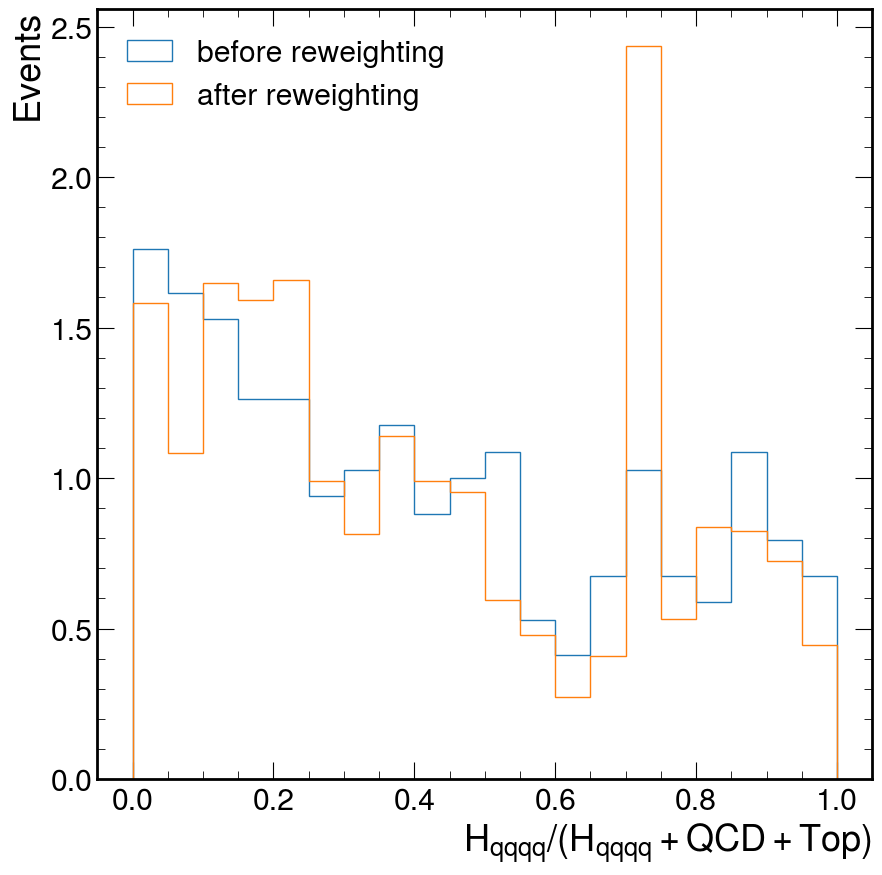

In [100]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
plt.legend(loc='upper left')
plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.ylabel('Events')
plt.show()
